### 회귀분석의 기본가정

 - 선형성 : 독립변수(X)와 종속변수(Y)는 선형관계이다
 - 독립성 : 종속변수(Y)는 서로 독립이어야 한다(한 관측 값이 다른 관측치에 의해 영향을 받으면 안됨)
 - 등분산성 : 독립변수 X의 값에 관계없이, 종속변수 Y의 분산은 일정하다
 - 정규성 : 독립변수(X)의 고정된 어떤 값에 대하여 종속변수(Y)는 정규분포를 따른다　

# 5.3 회귀분석 

In [2]:
#필요 라이브러리 로딩
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm #회귀 분석

In [3]:
# 실습활용을 위한 sklearn 패키지내 보스턴 주택가격 데이터 로딩
# sklearn 상위버전(1.2)에서 데이터 셋을 더이상 제공하지 않음

# from sklearn.datasets import load_boston
# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
#     data = load_boston()

# 상위버전 이용시 sklearn 참고 페이지 내 코드 실행하여 데이터 로딩
# data 및 target을 Dataframge으로 생성후 추후 marge

data_url = 'http://lib.stat.cmu.edu/datasets/boston'
raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2,:2]])
target = raw_df.values[1::2, 2] 

# 데이터 프레임 생성 및 Mearge
housing = pd.merge(pd.DataFrame(data), pd.DataFrame(target), left_index =True, right_index=True, how='inner')
housing.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
housing

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [4]:
boston_df = housing.copy()

### 데이터 컬럼 설명

#### 보스턴 인근 Town 별 주택 가격 밎 관련 정보 데이터셋

- CRIM :    per capita crime rate by town
- ZN :      proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS :   proportion of non-retail business acres per town
- CHAS :    Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX :     nitric oxides concentration (parts per 10 million)
- RM :      average number of rooms per dwelling
- AGE :     proportion of owner-occupied units built prior to 1940
- DIS :     weighted distances to five Boston employment centres
- RAD :     index of accessibility to radial highways
- TAX :     full-value property-tax rate per 10,000 dollar
- PTRATIO : pupil-teacher ratio by town
- B :       1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT :   persent lower status of the population
- MEDV :    Median value of owner-occupied homes in 1000 dollar's

# 단순 회귀
            MEDV = β_0 + β_1 * LSTAT + ∈
   - 주택 가격(중앙값)을 하위 소득 계층 비율로 설명하려고 하는 단수 회귀 식입니다.
      - 종속변수 : MEDV
      - 독립변수 : LSTAT
            

### 산점도로 변수간 관계 파악

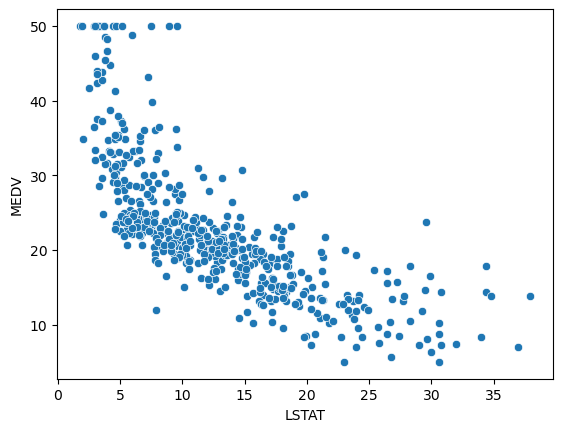

In [5]:
# 두 변수간 관계 파악을 위해 산점도
sns.scatterplot(x=boston_df['LSTAT'], y=boston_df['MEDV'])
plt.show()

LAST는 종속변수 MEDV와 비선형적 패턴이 있음을 확인 할 수 있습니다.

하지만 우선은 단순 회귀(1차식)으로 설명해 보겠습니다.

In [9]:
# 종속변수와 독립변수 설정 (np의 array로 뽑아냄)
MEDV = boston_df['MEDV'].values
LSTAT = boston_df['LSTAT'].values

### 독립변수에 상수항 결합

In [13]:
# 회귀모형 수식을 간단하게 만들기 위해 상수항을 독립변수에 추가해주어야 함.
# 상수항이 결합이 된다면, 원소가 1인 데이터가 추가가 됨
# 상수항이 결합되어야 가중치 (beta_0)가 행렬곱으로 들어왔을때 살아남을 수 있음. --> 수식이 매우 간단해짐
# 일반적으로 선형회귀는 늘 상수항 결합을 함.

LSTAT = sm.add_constant(LSTAT)

In [15]:
LSTAT # 2행의 숫자는 Beta_1을 의미함

array([[1.  , 4.98],
       [1.  , 9.14],
       [1.  , 4.03],
       ...,
       [1.  , 5.64],
       [1.  , 6.48],
       [1.  , 7.88]])

### 단순 선형 회귀분석

In [17]:
linear_mod = sm.OLS(MEDV, LSTAT) # statsmodels를 이용하여 종속변수, 독립변수를 인수로 추가

In [19]:
linear_mod #인스턴스

In [20]:
linear_result = linear_mod.fit() # linear_mod의 결과 확인을 위해 fit 매서드 활용

In [21]:
linear_result

In [22]:
print(linear_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           5.08e-88
Time:                        19:20:21   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.0

In [23]:
np.sqrt(linear_result.fvalue)

24.527899851187733

In [25]:
# R 스타일로 리그레션 하고 싶다면 from_fomula를 이용할 수 있음
linear_mod = sm.OLS.from_formula("MEDV ~ LSTAT", data=boston_df)
linear_result = linear_mod.fit()

In [26]:
print(linear_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           5.08e-88
Time:                        19:26:49   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

#### - R-squared 확인
#### - coefs는 beta_1에 대한 계수
우선 확인해야할것
종속변수, 독립변수, 종속변수의 설명력, 통계적 유의성,  R-squared

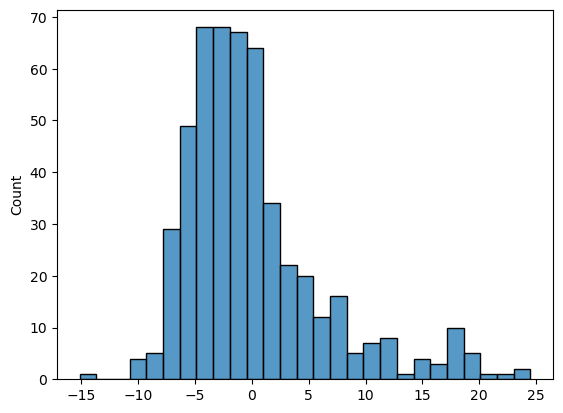

In [27]:
# 잔차 확인
sns.histplot(linear_result.resid)
plt.show()

## 선형화를 통한 회귀분석


### 상관관계 및 분포 확인

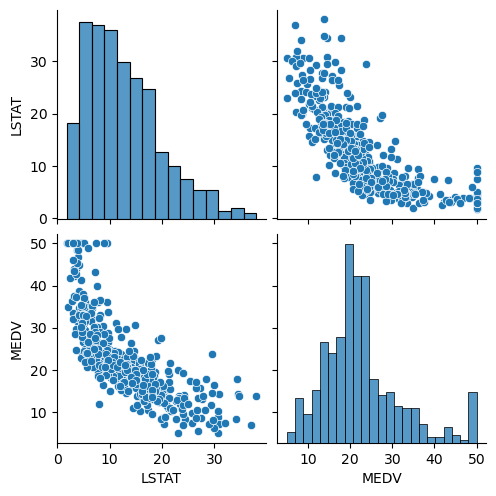

In [28]:
# 하위 계층 비율과 집 거래 중압값 관계확인
sns.pairplot(boston_df[['LSTAT', 'MEDV']])
plt.show()

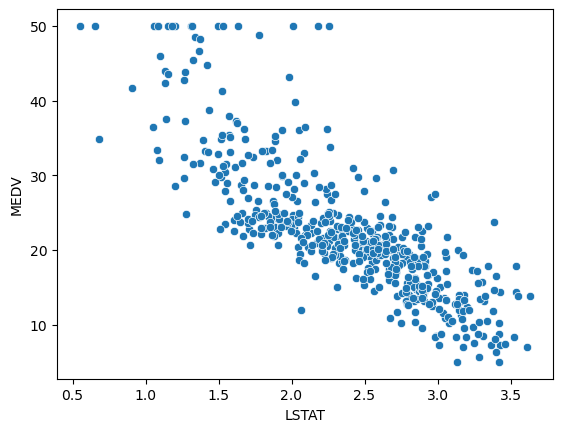

In [29]:
# LSTAT의 log변환
sns.scatterplot(x = np.log(boston_df['LSTAT']), y = boston_df['MEDV'] )
plt.show()

### 회귀분석

In [30]:
# 로그 변환 후 회귀분석 진행
log_linear_mod = sm.OLS.from_formula("MEDV ~ np.log(LSTAT)", data = boston_df)
log_linear_result = log_linear_mod.fit()

In [31]:
# summary table 출력
print(log_linear_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     1000.
Date:                Fri, 16 Feb 2024   Prob (F-statistic):          9.28e-122
Time:                        19:38:50   Log-Likelihood:                -1563.6
No. Observations:                 506   AIC:                             3131.
Df Residuals:                     504   BIC:                             3140.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        52.1248      0.965     54.004

   - 설명력(R-squared)이 0.1 가량 상승
   - 로그 전에는 LSTAT가 1증가할때 beta_1(coef)값 만큼 증가(음수의 경우 감소)
   - 로그 전에는 LSTAT가 1증가할때 beta_1(coef) 퍼센트 만큼 증가(음수의 경우 감소)

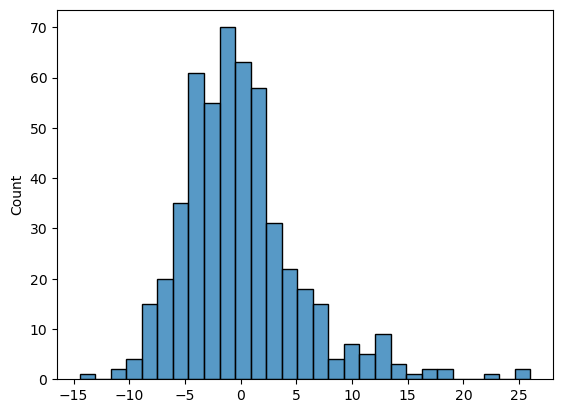

In [33]:
#잔차 확인
sns.histplot(log_linear_result.resid)
plt.show()

### 2차 회귀 분석(Quadratic Regression Model)

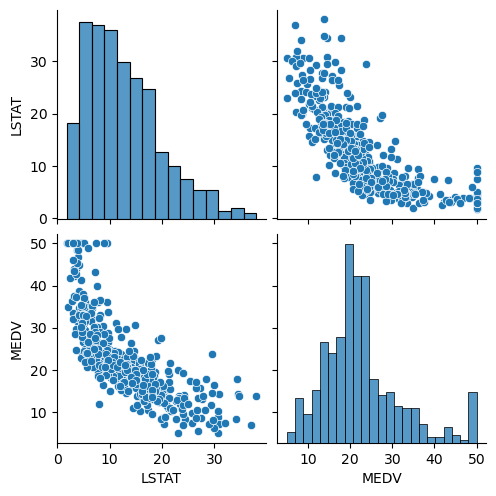

In [34]:
sns.pairplot(boston_df[['LSTAT', "MEDV"]])
plt.show()

두 변수간 커브 모양의 관계가 형성되어 있는 것을 확인할 수 있습니다.

이를 고려하기 위해 LSTAT 변수의 2차항을 추가 해 보겠습니다.

In [35]:
# 2차 회귀 분석 보델 설정

In [38]:
quadratic_mod = sm.OLS.from_formula('MEDV ~ LSTAT + I(LSTAT ** 2)', data = boston_df)
quadratic_result = quadratic_mod.fit()

In [41]:
# 결과 테이블 출력
print(quadratic_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Fri, 16 Feb 2024   Prob (F-statistic):          1.56e-112
Time:                        19:50:25   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149

### 잔차확인

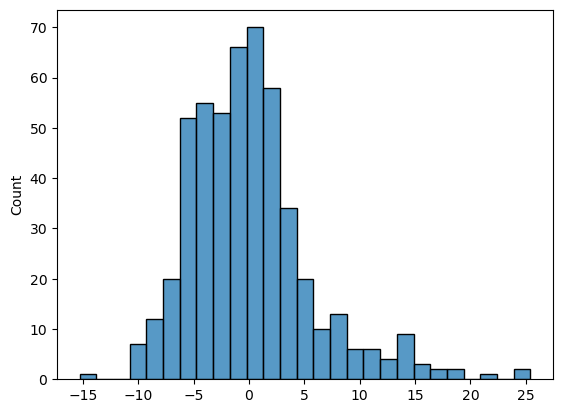

In [44]:
sns.histplot(quadratic_result.resid)
plt.show()

In [46]:
#3개 모델 결과 비교
print("R squared of linear model ---> {:.2f}".format(linear_result.rsquared))
print("R squared of log-linear model ---> {:.2f}".format(log_linear_result.rsquared))
print("R squared of quadratic model ---> {:.2f}".format(quadratic_result.rsquared))

R squared of linear model ---> 0.54
R squared of log-linear model ---> 0.66
R squared of quadratic model ---> 0.64


### 다중 회귀 (Multiple Regression)

방의 갯수를 알려주는 RM 변수 추가하여 분석을 진행

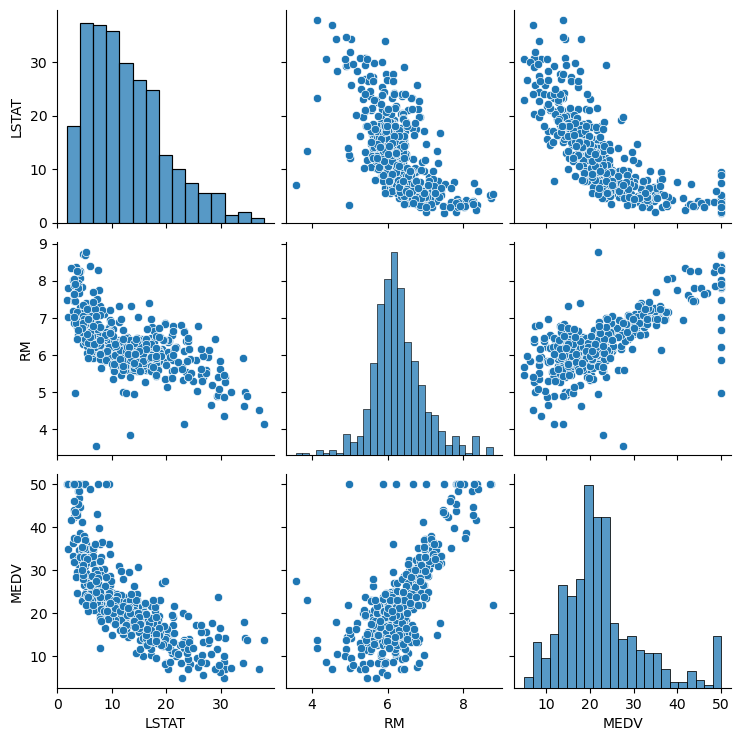

In [48]:
sns.pairplot(boston_df[['LSTAT', 'RM', 'MEDV']])
plt.show()

In [67]:
# RM 변수 추가시 두가지 옵션, 이미 평군값이기에 수치형으로도 볼 수 있음, 그리고 꽤 선형성을 나타냄
# 하지만 엄밀히 말하자면 범주형 변수임, 한개 두개 세개 네개 ... 2.5개와 같은 실수는 취할 수 없음. 이럴 때 binning처리 가능. 여기서는 아지 않을예정

multi_model = sm.OLS.from_formula('MEDV ~ RM + LSTAT + I(LSTAT ** 2)', data=boston_df)
multi_result = multi_model.fit()

In [68]:
print(multi_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     396.2
Date:                Fri, 16 Feb 2024   Prob (F-statistic):          6.50e-132
Time:                        20:09:46   Log-Likelihood:                -1533.0
No. Observations:                 506   AIC:                             3074.
Df Residuals:                     502   BIC:                             3091.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.6896      3.138      3.725

### 잔차 확인

<AxesSubplot:ylabel='Count'>

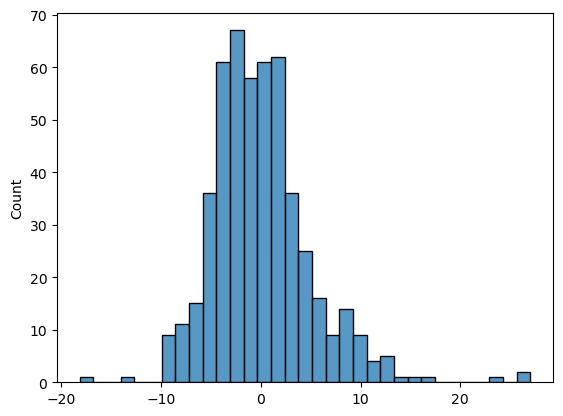

In [69]:
sns.histplot(multi_result.resid)

### 로그항 추가 (2차항 제거)

In [70]:
multi_model = sm.OLS.from_formula('MEDV ~ RM + np.log(LSTAT)', data=boston_df)
multi_result2 = multi_model.fit()

In [71]:
print(multi_result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     607.2
Date:                Fri, 16 Feb 2024   Prob (F-statistic):          7.40e-135
Time:                        20:09:47   Log-Likelihood:                -1529.6
No. Observations:                 506   AIC:                             3065.
Df Residuals:                     503   BIC:                             3078.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        22.8865      3.552      6.443

 - 다중회귀분석에서 변수가 여러개일 수록 'R-squared' 값이 증가하는 경향이 있으므로 'dj. R-squared' 값을 확인할것

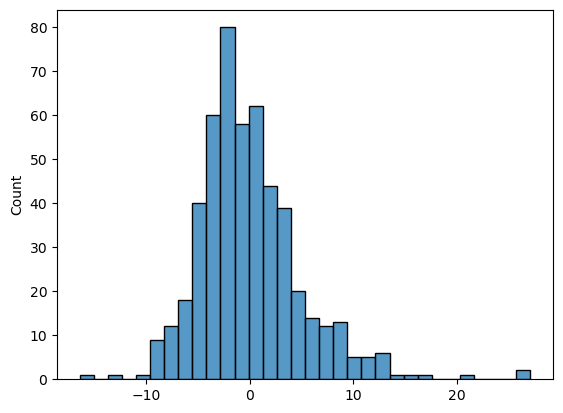

In [72]:
#잔차확인
sns.histplot(multi_result2.resid)
plt.show()

In [73]:
print("R squared of multiple model (2차항 포함) -> {:.2f}".format(multi_result.rsquared))
print("R squared of multiple model (로그 변환항 포함) -> {:.2f}".format(multi_result2.rsquared))

R squared of multiple model (2차항 포함) -> 0.70
R squared of multiple model (로그 변환항 포함) -> 0.71


In [74]:
# 기존 성능
print("R squared of linear model ---> {:.2f}".format(linear_result.rsquared))
print("R squared of log-linear model ---> {:.2f}".format(log_linear_result.rsquared))
print("R squared of quadratic model ---> {:.2f}".format(quadratic_result.rsquared))

R squared of linear model ---> 0.54
R squared of log-linear model ---> 0.66
R squared of quadratic model ---> 0.64
